In [3]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import os.path as osp
import GCL.losses as L
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np
import pandas as pd
import math
import torch.nn.functional as F


from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam

from scipy.io import loadmat
from dgl.nn.pytorch import GATConv, GraphConv, GATv2Conv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics
import scipy.sparse as sp

In [34]:
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn
from dgl.utils import expand_as_pair


class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, num_heads=1):
        super(GConv, self).__init__()
        self.act = nn.SELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(num_heads * hidden_dim)
        self.layers = nn.ModuleList()
        # self.layers.append(
        #     MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads,
        #               residual=False, feat_drop=0.5, attn_drop=0.5)
        # )
        # for _ in range(1, num_layers):
        #     self.layers.append(
        #         MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True,
        #                   num_heads=num_heads, residual=False, feat_drop=0.5, attn_drop=0.5)
        #     )
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph, edge_weight=None):
        z = x
        attn = None
        for i in range(self.num_layers):
            # z, attn = self.layers[i](graph, z, attn)
            # z = self.layers[i](graph, z, edge_weight=edge_weight)
            z = self.layers[i](graph, z)
            # z = z.flatten(1)
            z = self.act(z)
            z = self.norm(z)
        # z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))
        # z = self.layers[-1](graph, z)
        return z


class Encoder(nn.Module):
    def __init__(self, graph, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3):
        super(Encoder, self).__init__()

        self.encoder = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers, num_heads=num_heads).to(
            device)

        # self.decoder = nn.Sequential(
        #     nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
        #     nn.SELU(),
        #     nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
        #     nn.SELU(),
        # )

        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))
        self.device = torch.device('cuda')

        self.instance_projector = nn.Sequential(
            nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
            nn.ELU(),
            nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
            # nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
        )

        self.cluster_projector = nn.Sequential(
            nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
            nn.ELU(),
            nn.Linear(num_heads * hidden_dim, n_clusters),
            # nn.Linear(num_heads * hidden_dim, n_clusters),
            nn.Softmax(dim=1)
        )

    def forward(self, x, graph, edge_index, edge_weight=None):
        aug1, aug2 = self.augmentor
        z = self.encoder(x, graph, edge_weight)
        # z = self.decoder(z)

        x1, edge_index1, edge_weight1 = aug1(x, edge_index, edge_weight)
        graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
        graph1.add_self_loop()
        # graph1, x1 = aug(graph, x, 0.3, 0.3)
        z1 = self.encoder(x1, graph1, edge_weight1)

        x2, edge_index2, edge_weight2 = aug2(x, edge_index, edge_weight)
        graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
        graph2.add_self_loop()
        # graph2, x2 = aug(graph, x, 0.3, 0.3)
        z2 = self.encoder(x2, graph2, edge_weight2)

        c1 = self.cluster_projector(z1)
        c2 = self.cluster_projector(z2)
        z1 = self.instance_projector(z1)
        z2 = self.instance_projector(z2)

        return z, z1, z2, c1, c2, self.cluster_projector(z)


class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [5]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()



In [6]:

device = torch.device('cuda')
path = osp.join(osp.pardir, 'datasets', 'ACM')


In [24]:
# print(len(mat['MDM']))

In [7]:
def load_graph(dataset):
    data = np.loadtxt(osp.join(osp.pardir, 'datasets', 'ACM', dataset + '.txt'), dtype=np.int32)
    n, _ = data.shape

    idx = np.array([i for i in range(n)], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt(osp.join(osp.pardir, 'datasets', 'ACM', dataset + '_graph.txt'), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(n, n), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = adj + sp.eye(adj.shape[0])
    # adj = normalize(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

adj = load_graph('acm').to(device)



In [8]:
print(adj._values().size())
graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=3025).to(device)
graph.remove_self_loop()
graph.add_self_loop()
edge_weight = adj._values()

edge_index = torch.stack(graph.edges())
print(graph)
print(edge_weight)
print(edge_index)

torch.Size([29281])
Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={})
tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')
tensor([[   0,    8,   20,  ..., 2983, 2991, 3024],
        [   0,    0,    0,  ..., 3024, 3024, 3024]], device='cuda:0')


In [10]:
x = tensor(np.load(osp.join(path, 'acm_feat.npy')), dtype=torch.float).to(device)
y = tensor(np.load(osp.join(path, 'acm_label.npy'))).to(device)
print(x.size())


torch.Size([3025, 1870])


In [11]:
# del adj


model have 2273795 paramerters in total


(T): 100%|██████████| 500/500 [00:41<00:00, 11.99it/s, loss=9.15, con_loss=7.86, kl_loss=1.29]


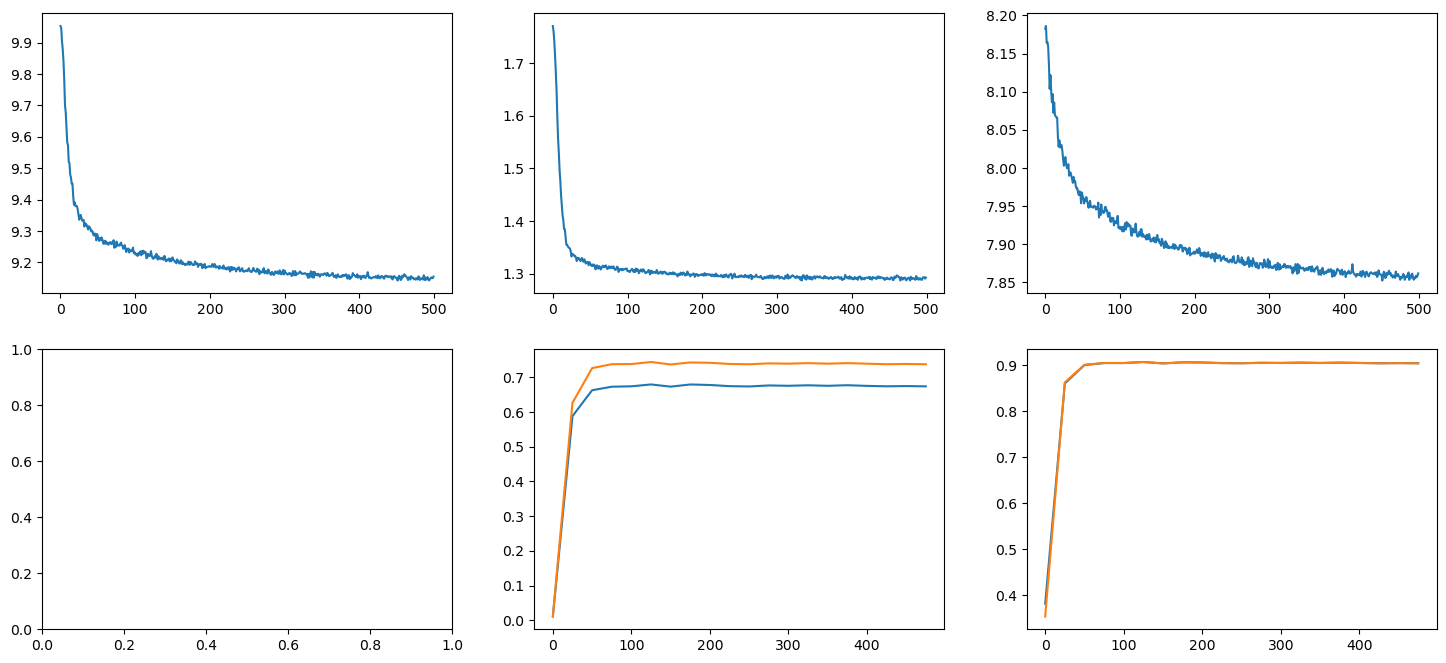

[MAX]ACC:  0.9071074380165289
[MAX]ARI:  0.7440703961556377
[MAX]NMI:  0.6794272924819803
[MAX]F1:  0.9070768825557948


In [60]:
from GCL.models import DualBranchContrast, WithinEmbedContrast


def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro


# def train(encoder_model, contrast_model, optimizer, x, graph, edge_index, clu_loss_func=ClusterLoss(class_num=4, temperature=1, device=device)):
def train(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
          clu_loss_func=DualBranchContrast(loss=L.InfoNCE(tau=1), mode='L2L', intraview_negs=True).to(device)):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, c1, c2, _ = encoder_model(x, graph, edge_index, edge_weight)
    con_loss = contrast_model(z1, z2)
    clu_loss = clu_loss_func(c1.t(), c2.t())
    # clu_loss = contrast_model(c1.t(), c2.t())
    # clu_loss = 0.01 * contrast_model(c1.t(), c2.t())
    # con_loss = 0.01 * con_loss
    loss = (con_loss + clu_loss)

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


aug1 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureMasking(pf=0.3)])
aug2 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureMasking(pf=0.3)])
# aug1 = A.Identity()
# aug2 = A.RandomChoice([A.NodeDropping(pn=0.1),
#                        A.FeatureMasking(pf=0.1),
#                        A.EdgeRemoving(pe=0.1)], 1)
# encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=32, num_heads=4, n_clusters=4, num_layers=2).to(device)
encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=512, num_heads=1, n_clusters=3, num_layers=3).to(device)

print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

# contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=1), mode='L2L', intraview_negs=True).to(device)
# contrast_model = nn.MSELoss()
# contrast_model = WithinEmbedContrast(loss=L.VICReg()).to(device)

# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer = Adam(encoder_model.parameters(), lr=0.0001, weight_decay=1e-6)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs = 500

kmeans = KMeans(n_clusters=3)

with tqdm(total=epochs, desc='(T)') as pbar:
    for epoch in range(epochs):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)
        ratios.append((100 * kl_loss) / loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, _, _ = encoder_model(x, graph, edge_index, edge_weight)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(y.cpu(), pred)
            ari = adjusted_rand_score(y.cpu(), pred)
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)
            accs.append((epoch, acc))
            f1s.append((epoch, f1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs), losss)
axes[0][1].plot(range(epochs), kl_losss)
axes[0][2].plot(range(epochs), con_losss)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


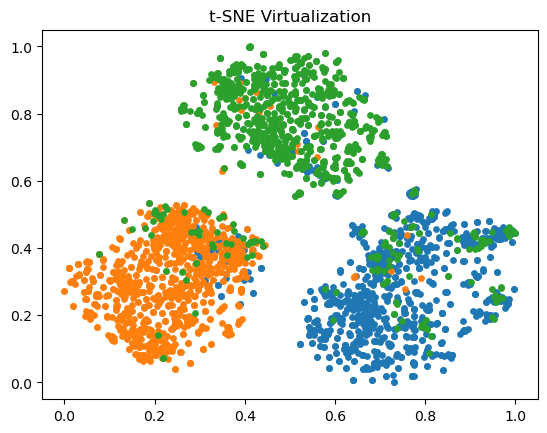

0.6732959051977054 0.7368385009882598


In [61]:
from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _, _ = encoder_model(x, graph, edge_index, edge_weight)
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(y.cpu() == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

nmi = normalized_mutual_info_score(y.cpu(), pred)
ari = adjusted_rand_score(y.cpu(), pred)

# acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(nmi, ari)

D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


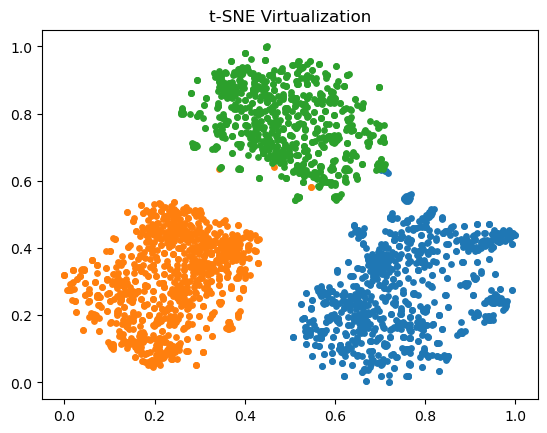

0.6697126133562343 0.7334310873997175


In [62]:
with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _, pred = encoder_model(x, graph, edge_index)
    pred = torch.argmax(pred, dim=1).cpu()
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

nmi = normalized_mutual_info_score(y.cpu(), pred)
ari = adjusted_rand_score(y.cpu(), pred)

# acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(nmi, ari)


In [63]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _ = encoder_model(x, graph, edge_index)

pred = kmeans.fit_predict(z.cpu())

nmi = normalized_mutual_info_score(y.cpu(), pred)
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(y.cpu(), pred)
print('[INFO]ARI: ', ari)



ValueError: too many values to unpack (expected 5)

In [ ]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

In [ ]:


from dgl import AddSelfLoop
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset
transform = (AddSelfLoop())
data = CoraGraphDataset(transform=transform)


In [ ]:
print(data[0])
print(data[0].edges())